In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 1. Load Data
# Columns based on your sample: ID, Entity, Sentiment, Content
col_names = ['Tweet_ID', 'Entity', 'Sentiment', 'Tweet_Content']

train_df = pd.read_csv('twitter_training.csv', names=col_names, header=None)
val_df = pd.read_csv('twitter_validation.csv', names=col_names, header=None)

# 2. Basic Cleaning
# Drop rows where tweet content is missing (NaN)
train_df.dropna(subset=['Tweet_Content'], inplace=True)
val_df.dropna(subset=['Tweet_Content'], inplace=True)

# 3. Handling the 'Irrelevant' Class
# Goal: Treat Irrelevant as Neutral
train_df['Sentiment'] = train_df['Sentiment'].replace('Irrelevant', 'Neutral')
val_df['Sentiment'] = val_df['Sentiment'].replace('Irrelevant', 'Neutral')

print(f"Training Shape: {train_df.shape}")
print(f"Validation Shape: {val_df.shape}")
print(train_df.head())

Training Shape: (73996, 4)
Validation Shape: (1000, 4)
   Tweet_ID       Entity Sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                       Tweet_Content  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  


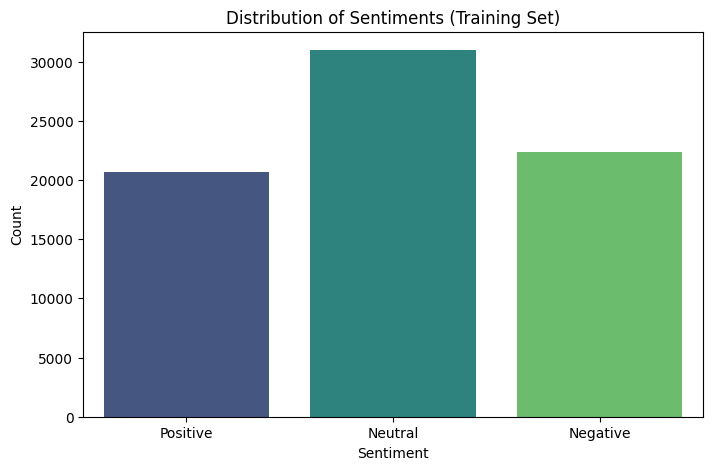

In [2]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Sentiment', data=train_df, palette='viridis')
plt.title('Distribution of Sentiments (Training Set)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

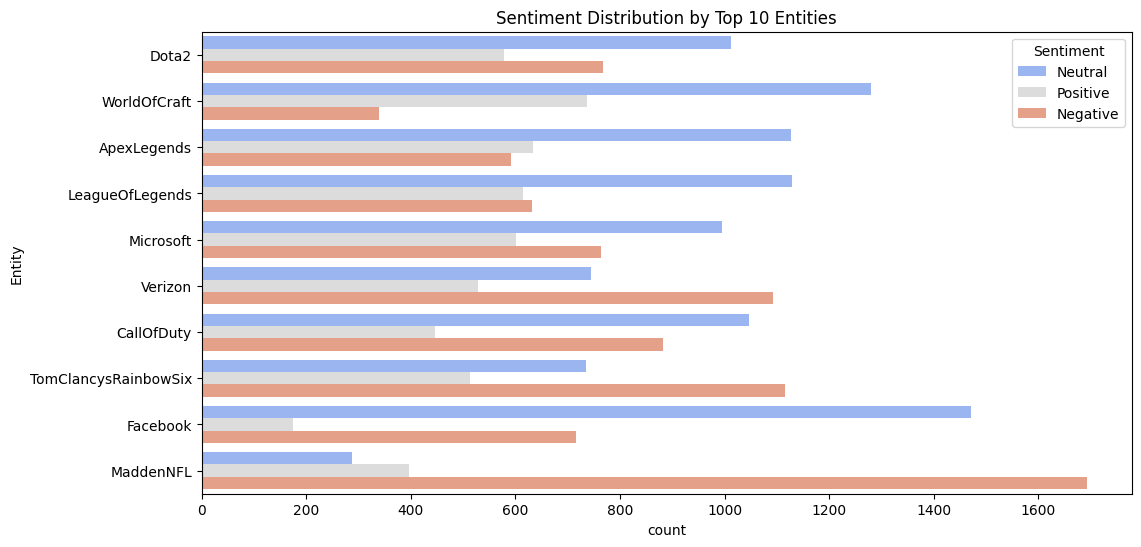

In [3]:
plt.figure(figsize=(12, 6))
# Plot top 10 entities
top_entities = train_df['Entity'].value_counts().head(10).index
sns.countplot(y='Entity', data=train_df[train_df['Entity'].isin(top_entities)], 
              hue='Sentiment', palette='coolwarm')
plt.title('Sentiment Distribution by Top 10 Entities')
plt.show()

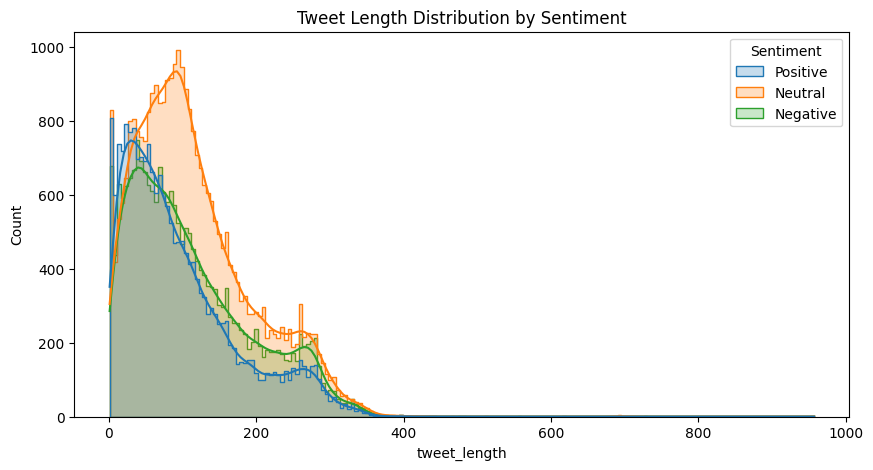

In [4]:
train_df['tweet_length'] = train_df['Tweet_Content'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(data=train_df, x='tweet_length', hue='Sentiment', kde=True, element="step")
plt.title('Tweet Length Distribution by Sentiment')
plt.show()

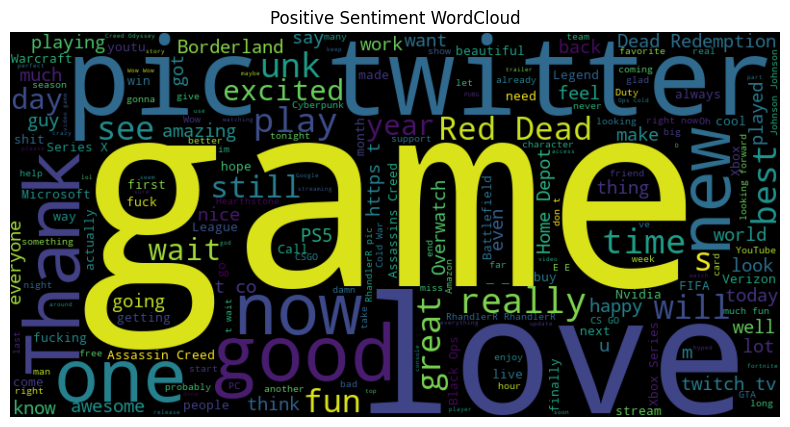

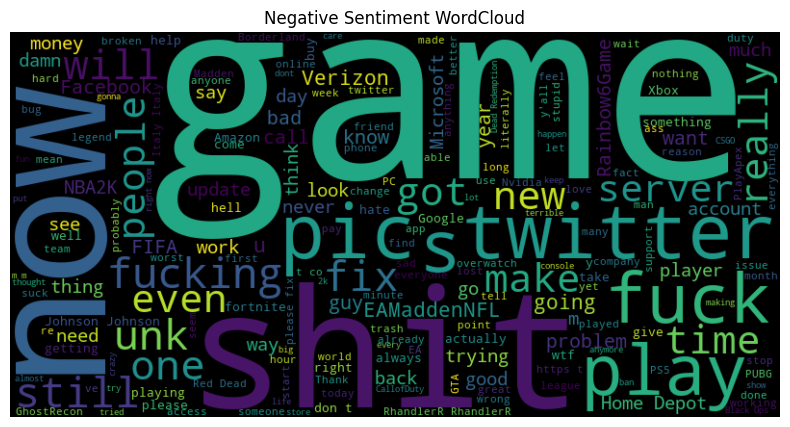

In [5]:
from wordcloud import WordCloud

def generate_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, background_color='black').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Join all positive tweets
positive_text = " ".join(train_df[train_df['Sentiment'] == 'Positive']['Tweet_Content'].astype(str))
generate_wordcloud(positive_text, "Positive Sentiment WordCloud")

# Join all negative tweets
negative_text = " ".join(train_df[train_df['Sentiment'] == 'Negative']['Tweet_Content'].astype(str))
generate_wordcloud(negative_text, "Negative Sentiment WordCloud")

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str): return ""
    
    # 1. Lowercase
    text = text.lower()
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 3. Remove User @ references and '#'
    text = re.sub(r'\@\w+|\#','', text)
    # 4. Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # 5. Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    
    return " ".join(tokens)

# Apply cleaning
print("Cleaning data... this may take a moment.")
train_df['clean_text'] = train_df['Tweet_Content'].apply(clean_text)
val_df['clean_text'] = val_df['Tweet_Content'].apply(clean_text)

# Label Encoding (Negative=0, Neutral=1, Positive=2)
le = LabelEncoder()
y_train = le.fit_transform(train_df['Sentiment'])
y_val = le.transform(val_df['Sentiment'])

# Save the encoder classes for later inference
print(f"Classes: {le.classes_}") # ['Negative' 'Neutral' 'Positive']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NagendraB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\NagendraB\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cleaning data... this may take a moment.
Classes: ['Negative' 'Neutral' 'Positive']


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import joblib

# 1. Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(train_df['clean_text'])
X_val_tfidf = tfidf.transform(val_df['clean_text'])

# 2. Train Logicstic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# 3. Evaluate
y_pred_lr = lr_model.predict(X_val_tfidf)
print("### Logistic Regression Results ###")
print(f"Accuracy: {accuracy_score(y_val, y_pred_lr):.4f}")
print(classification_report(y_val, y_pred_lr, target_names=le.classes_))

# 4. Save Weights
joblib.dump(lr_model, 'sentiment_lr_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

### Logistic Regression Results ###
Accuracy: 0.8130
              precision    recall  f1-score   support

    Negative       0.80      0.82      0.81       266
     Neutral       0.82      0.82      0.82       457
    Positive       0.81      0.79      0.80       277

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000



['tfidf_vectorizer.pkl']

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical

# 1. Tokenization
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['clean_text'])

X_train_seq = tokenizer.texts_to_sequences(train_df['clean_text'])
X_val_seq = tokenizer.texts_to_sequences(val_df['clean_text'])

# 2. Padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

# One-hot encode labels for Keras
y_train_cat = to_categorical(y_train, 3)
y_val_cat = to_categorical(y_val, 3)

# 3. Build Model
model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax') # 3 Output classes
])

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. Train
history = model_lstm.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_val_pad, y_val_cat),
    epochs=5,
    batch_size=32,
    verbose=1
)

# 5. Save Model
model_lstm.save('sentiment_bilstm_model.h5')
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("LSTM Model Saved.")

Epoch 1/5
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 221s 91ms/step - accuracy: 0.6993 - loss: 0.6890 - val_accuracy: 0.8950 - val_loss: 0.3171
Epoch 2/5
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 317s 137ms/step - accuracy: 0.8435 - loss: 0.3943 - val_accuracy: 0.9300 - val_loss: 0.2090
Epoch 3/5
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 181s 78ms/step - accuracy: 0.8835 - loss: 0.2916 - val_accuracy: 0.9460 - val_loss: 0.1689
Epoch 4/5
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 258s 111ms/step - accuracy: 0.9057 - loss: 0.2356 - val_accuracy: 0.9560 - val_loss: 0.1494
Epoch 5/5
2313/2313 ━━━━━━━━━━━━━━━━━━━━ 198s 86ms/step - accuracy: 0.9205 - loss: 0.1988 - val_accuracy: 0.9500 - val_loss: 0.1567


LSTM Model Saved.


In [9]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

# 1. Label columns already prepared
train_df["label"] = y_train
val_df["label"] = y_val

# 2. Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def encode_batch(batch):
    return tokenizer(
        batch["clean_text"],
        truncation=True,
        padding="max_length",
        max_length=60
    )

# 3. Convert to HF datasets
train_ds = Dataset.from_pandas(train_df[["clean_text", "label"]]).map(encode_batch, batched=True)
val_ds   = Dataset.from_pandas(val_df[["clean_text", "label"]]).map(encode_batch, batched=True)

# Remove leftover columns from pandas
try:
    train_ds = train_ds.remove_columns(["clean_text", "__index_level_0__"])
    val_ds   = val_ds.remove_columns(["clean_text", "__index_level_0__"])
except Exception:
    pass

# 4. Tiny BERT (memory friendly)
model = BertForSequenceClassification.from_pretrained(
    "prajjwal1/bert-tiny",
    num_labels=3
)

# 5. TRAINING ARGUMENTS (ONLY supported args for ALL versions)
training_args = TrainingArguments(
    output_dir="./bert_sentiment",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
)

# 6. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer
)

print("Training...")
trainer.train()

print("Saving model...")
trainer.save_model("./bert_sentiment")
tokenizer.save_pretrained("./bert_sentiment")

print("Evaluating...")
metrics = trainer.evaluate()
print(metrics)



Map: 100%|██████████| 1000/1000 [00:00<00:00, 3811.55 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training...


Step,Training Loss
500,1.042300
1000,0.929000
1500,0.878700
2000,0.848800
2500,0.823200
3000,0.802500
3500,0.782100
4000,0.775300
4500,0.760600
5000,0.742900


Saving model...
Evaluating...


{'eval_loss': 0.6100185513496399, 'eval_runtime': 1.2278, 'eval_samples_per_second': 814.434, 'eval_steps_per_second': 26.062, 'epoch': 3.0}


In [10]:
y_pred_lr = lr_model.predict(X_val_tfidf)
print("Accuracy:", accuracy_score(y_val, y_pred_lr))
print(classification_report(y_val, y_pred_lr, target_names=le.classes_))


Accuracy: 0.813
              precision    recall  f1-score   support

    Negative       0.80      0.82      0.81       266
     Neutral       0.82      0.82      0.82       457
    Positive       0.81      0.79      0.80       277

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000



In [11]:
acc_lr = accuracy_score(y_val, y_pred_lr)


In [12]:
y_pred_lstm = model_lstm.predict(X_val_pad)
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)

acc_lstm = accuracy_score(y_val, y_pred_lstm)

print("BiLSTM Accuracy:", acc_lstm)
print(classification_report(y_val, y_pred_lstm, target_names=le.classes_))


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step
BiLSTM Accuracy: 0.95
              precision    recall  f1-score   support

    Negative       0.94      0.95      0.95       266
     Neutral       0.96      0.96      0.96       457
    Positive       0.94      0.94      0.94       277

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



In [13]:
import numpy as np
outputs = trainer.predict(val_ds)
y_pred_bert = np.argmax(outputs.predictions, axis=1)

acc_bert = accuracy_score(y_val, y_pred_bert)

print("Tiny BERT Accuracy:", acc_bert)
print(classification_report(y_val, y_pred_bert, target_names=le.classes_))


Tiny BERT Accuracy: 0.747
              precision    recall  f1-score   support

    Negative       0.71      0.79      0.75       266
     Neutral       0.78      0.76      0.77       457
    Positive       0.73      0.69      0.71       277

    accuracy                           0.75      1000
   macro avg       0.74      0.74      0.74      1000
weighted avg       0.75      0.75      0.75      1000



In [14]:
accuracies = {
    "Logistic Regression": acc_lr,
    "BiLSTM": acc_lstm,
    "Tiny BERT": acc_bert
}

best_model_name = max(accuracies, key=accuracies.get)
print("Best Model:", best_model_name)
print("Accuracies:", accuracies)


Best Model: BiLSTM
Accuracies: {'Logistic Regression': 0.813, 'BiLSTM': 0.95, 'Tiny BERT': 0.747}
